##### 1- Start by pulling down Python 3, SKLearn, Pandas, and any dependencies. Pull down either the titanic dataset or the telco churn dataset. Load the dataset into Python, split off a validation dataset of 20% of your data, chosen randomly. With the remaining 80%, train a decision tree to classify the outcome (churn or survive). Use 10-fold cross-validation to get a true positive rate and false positive rate. Visualize a ROC curve (and understand what it is) and then use your 20% validation set to double check your metrics. How close were the metrics created by 10-fold CV?

### Notes:
* Dataset link: https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/
* "Churn" is defined as the customer having left in the past month

### Load modules and dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import subprocess
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
telco = pd.read_csv(r"/Users/ryanbasques/PythonProjects/Trevor's 7 Steps/WA_Fn-UseC_-Telco-Customer-Churn.csv")
telco.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


### Data preparation

Sklearn does not accept string formatted features. Variables to binarize: *gender, Partner, Dependents, PhoneService, PaperlessBilling*

In [3]:
normalized = telco.copy()

In [4]:
#TotalCharges space character preventing numeric data type
normalized['TotalCharges'] = np.where(normalized['TotalCharges']==" ",0,normalized['TotalCharges'])
normalized['TotalCharges'] = normalized['TotalCharges'].astype('float')

In [5]:
#binary variables
for feature in ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    normalized[feature] = pd.get_dummies(normalized[feature], prefix=feature, drop_first=True) #binarize

In [6]:
#other categorical variables
normalized = pd.get_dummies(normalized, columns=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                'PaymentMethod'])

In [7]:
#Get rid of customerID
normalized.drop('customerID', axis=1, inplace=True)

### Split train/test sets: 80% / 20%

In [8]:
normalized = normalized.astype('float32')

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(normalized.loc[:, normalized.columns != 'Churn'], normalized['Churn'], test_size=0.2, random_state=33)

### Decision Tree Classification

In [10]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)

Decision tree visualization - code borrowed from: http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html

In [11]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = [r"/usr/local/Cellar/graphviz/2.40.1/bin/dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except Exception as exc:
        print(exc)
        
visualize_tree(clf, X_train.columns)

### Model Selection
Different scoring parameters: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_accuracy = cross_val_score(clf, X_train, Y_train, cv=10)
accuracy_score = np.mean(cross_val_accuracy)
print("Accuracy score:", accuracy_score)

cross_val_precision = cross_val_score(clf, X_train, Y_train, cv=10, scoring='precision')
precision_score = np.mean(cross_val_precision)
print("Precision score (True Positive Rate)", precision_score)

cross_val_recall = cross_val_score(clf, X_train, Y_train, cv=10, scoring='recall')
recall_score = np.mean(cross_val_recall)
print("Recall score (False Positive Rate)", recall_score)

cross_val_roc = cross_val_score(clf, X_train, Y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc)
print("ROC score (Area Under Curve)", roc_score)

Accuracy score: 0.728087540413
Precision score (True Positive Rate) 0.483010586702
Recall score (False Positive Rate) 0.498081806639
ROC score (Area Under Curve) 0.65277778687


### Plot ROC Curve
Plotting an ROC Curve: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

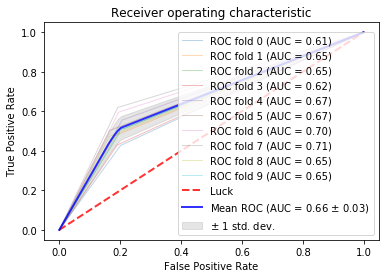

In [13]:
import matplotlib.pyplot as plt
from itertools import cycle

from scipy import interp

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0

# for train, test in cv.split(X_train, Y_train):
for train, test in cv.split(X_train, Y_train):
#     v = clf.fit(X_train.iloc[train], Y_train.iloc[train])
    probas_ = clf.fit(X_train.iloc[train], Y_train.iloc[train]).predict_proba(X_train.iloc[test])
    #Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_train.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


### Using 20% hold-out to check metrics

In [14]:
clf.score(X=X_test, y=Y_test)

0.72320794889992901

##### Accuracy reported from the cross validation (79%) is very close to the actual accuracy reported from the test set (78%).

### Step 2

#### Tune the hyperparameters for the decision tree. Some hyperparameters include the impurity metric (GINI etc) or the number of children per branch. see if you can find any useful Python packages or tools within sklearn which might help you to do this. You might need to use a different metric like Logarithmic Loss in order to automatically optimize the model. Once you've trained a new, optimized version of your decision tree, compare the validation ROC curve against the one from item 1, which was just using the default hyperparameters.

In [15]:
%%time

max_depth_range = range(2, 12)
criterion = ['gini', 'entropy']
# min_samples_split_range = range(2,38,5) #min is 2, will increment by 5
# min_samples_leaf_range = range(2,38,5)
max_features_range = range(20, len(X_train.columns), 2)

#*Started out with too many variations where the compute time would have taken hours. Oops!*

treeResults = []

tree_count = 0
for depth in max_depth_range:
    for c in criterion:
#         for split_samples in min_samples_split_range:
#             for leaf_samples in min_samples_leaf_range:
        for feature_num in max_features_range:
#                     tempClf = tree.DecisionTreeClassifier(max_depth=depth, criterion=c, min_samples_split=split_samples,
#                                                          min_samples_leaf=leaf_samples, max_features=feature_num)
            tempClf = tree.DecisionTreeClassifier(max_depth=depth, criterion=c, max_features=feature_num)
            tempClf = tempClf.fit(X_train, Y_train)

            cross_val_roc = cross_val_score(clf, X_train, Y_train, cv=10, scoring='roc_auc')
            roc_score = np.mean(cross_val_roc)

#                     treeResults.append([tree_count, depth, c, split_samples, leaf_samples, feature_num, roc_score])
            treeResults.append([tree_count, depth, c, feature_num, roc_score])

            tree_count += 1

print("Trees iterated:", tree_count)

# resultColumns = ['tree_ID', 'max_depth', 'criterion', 'min_split_samples', 'min_leaf_samples',
#                  'max_feature_num', 'roc_score']

resultColumns = ['tree_ID', 'max_depth', 'criterion',
                 'max_feature_num', 'roc_score']

Trees iterated: 200
CPU times: user 49 s, sys: 342 ms, total: 49.4 s
Wall time: 50.9 s


In [16]:
treeResultsGrid = pd.DataFrame(treeResults, columns=resultColumns)
treeResultsGrid.sort_values(by='roc_score', ascending=False).head()
#Had to limit the manual parameters I searched because of how long it takes. Using the three above, it looks like the
#best combination is max tree depth of 10, entropy criterion, max features of 36.

#However, because a depth of 10 is much more likely to overfit the data, and a max depth of 5 only sacrifices .001
#ROC score, I would likely opt for the second option - max depth 3, entropy criterion, 32 max features.

,tree_ID,max_depth,criterion,max_feature_num,roc_score
11,11,2,entropy,22,0.663552
73,73,5,entropy,26,0.663439
50,50,4,entropy,20,0.661378
63,63,5,gini,26,0.660487
86,86,6,gini,32,0.660366


### Prepare for automatic hyperparameter tuning
Helpful link: http://scikit-learn.org/stable/modules/grid_search.html

In [17]:
clf.get_params() #all possible hyperparameters

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [18]:
%%time

#Grid search
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth':[x for x in range(1,8)],
    'criterion':('gini', 'entropy'),
#     {'min_samples_split':[x for x in range(2,100,2)]} #did not help
    'max_leaf_nodes':[x for x in range(2,50,2)]}
]

clf = DecisionTreeClassifier()
gridSearch = GridSearchCV(clf, param_grid, cv=10)
gridSearch.fit(X_train, Y_train)

print("MEAN_ACCURACY_SCORING")
print(gridSearch.best_estimator_)
print(gridSearch.best_params_)
print(gridSearch.best_score_)

gridSearchLL = GridSearchCV(clf, param_grid, cv=10, scoring='neg_log_loss') #log loss scoring
gridSearchLL.fit(X_train, Y_train)

print("LOG_LOSS_SCORING")
print(gridSearchLL.best_estimator_)
print(gridSearchLL.best_params_)
print(gridSearchLL.best_score_)

#This seems about as fast as the version I built above, but simpler to use.

MEAN_ACCURACY_SCORING
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
{'criterion': 'gini', 'max_depth': 6, 'max_leaf_nodes': 20}
0.797479588214
LOG_LOSS_SCORING
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=14,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
{'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 14}
-0.425333702529
CPU times: user 1min 20s, sys: 538 ms, total: 1min 21s
Wall time: 1min 22s


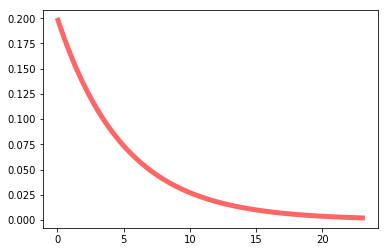

In [19]:
#exploring different distributions for use in randomized search below
test = scipy.stats.expon(scale=5) #exponential distribution
fig, ax = plt.subplots(1, 1)
x = np.linspace(test.ppf(0.01), test.ppf(0.99), 100)
ax.plot(x, test.pdf(x), 'r-', lw=5, alpha=0.6)

In [20]:
%%time

#Randomized search
from sklearn.model_selection import RandomizedSearchCV

clf = DecisionTreeClassifier()

param_grid = {'max_depth':range(1,50),
             'criterion':['gini', 'entropy'],
             'max_leaf_nodes':range(2,80)}


randomSearch = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=100)

randomSearch.fit(X_train, Y_train)

print("MEAN_ACCURACY_SCORING")
print(randomSearch)
print(randomSearch.best_estimator_)
print(randomSearch.best_params_)
print(randomSearch.best_score_)

randomSearchLL = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=100, scoring='neg_log_loss')

randomSearchLL.fit(X_train, Y_train)

print("LOG_LOSS_SCORING")
print(randomSearchLL)
print(randomSearchLL.best_estimator_)
print(randomSearchLL.best_params_)
print(randomSearchLL.best_score_)

MEAN_ACCURACY_SCORING
RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'max_depth': range(1, 50), 'criterion': ['gini', 'entropy'], 'max_leaf_nodes': range(2, 80)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=32,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
      

Grid search and randomized searched returned very different results. It looks like grid search
performed better in both scoring metrics (mean accuracy, log loss). This may be because I
did not define the sampling distributions well enough, or set the number of iterations high enough
for the randomized search.

In [21]:
#Compare ROC from base model (with default hyperparameters) to ROC from best model found ({'criterion': 'gini', 'max_depth': 6, 'max_leaf_nodes': 20})

#Base Model
base = DecisionTreeClassifier()
cross_val_roc = cross_val_score(base, X_train, Y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc)
print("ROC score (Area Under Curve) for base", roc_score)

#Model from Grid Search
gridTree = DecisionTreeClassifier(max_depth=6, max_leaf_nodes=20)
cross_val_roc = cross_val_score(gridTree, X_train, Y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc)
print("ROC score (Area Under Curve) for gridTree", roc_score)


ROC score (Area Under Curve) for base 0.655249035546
ROC score (Area Under Curve) for gridTree 0.828977760676


In [24]:
# from sklearn.metrics import roc_auc_score
# #Optimized decision tree from previous steps
# gridTree.fit(X_train, Y_train)
# y_score = gridTree.predict(X_test)
# roc_auc_score(Y_test, y_score)

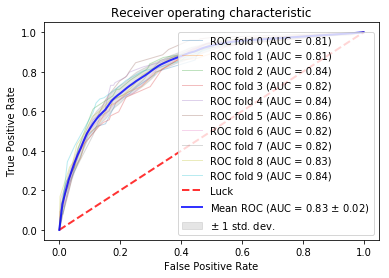

In [45]:
#Plot the Grid Search tree ROC (same code as above)
cv = StratifiedKFold(n_splits=10)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0

for train, test in cv.split(X_train, Y_train):
    probas_ = gridTree.fit(X_train.iloc[train], Y_train.iloc[train]).predict_proba(X_train.iloc[test])
    #Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_train.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
